<a href="https://colab.research.google.com/github/muhdlaziem/DR/blob/master/DenseNet(5_classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/'My Drive'/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [ ]:
%tensorflow_version 1.x

In [ ]:
nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.set_random_seed(nr_seed)
print(tf.__version__)

1.15.2


In [ ]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
# Image size
im_size = 320
# Batch size
BATCH_SIZE = 20

# Loading

In [ ]:
%cd diabetic-retinopathy-resized/
DR = pd.read_csv('5_3_2_levels.csv')
DR.head()

/gdrive/My Drive/diabetic-retinopathy-resized


,image,level,level(3),level(2)
0,10_left.jpeg,0,0,0
1,10_right.jpeg,0,0,0
2,13_left.jpeg,0,0,0
3,13_right.jpeg,0,0,0
4,15_left.jpeg,1,1,1


In [ ]:
DR['level'].value_counts()

0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64

## Under Sampling

In [ ]:
index_0 = DR[DR['level']==0].sample(25802-800).index
index_1 = DR[DR['level']==1].sample(2438-753).index
index_2 = DR[DR['level']==2].sample(5288-739).index
index_3 = DR[DR['level']==3].sample(872-710).index
index_4 = DR[DR['level']==4].sample(708-708).index

undersampling_DR = DR.drop(index_0)
undersampling_DR = undersampling_DR.drop(index_1)
undersampling_DR = undersampling_DR.drop(index_2)
undersampling_DR = undersampling_DR.drop(index_3)
undersampling_DR = undersampling_DR.drop(index_4)

undersampling_DR['level'].value_counts()

0    800
1    753
2    739
3    710
4    708
Name: level, dtype: int64

## Train - Valid split

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(undersampling_DR,test_size=0.30, random_state=42)

In [ ]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(2597, 4)
(1113, 4)


## Process Images

Crop function: https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping 

In [ ]:
def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

/gdrive/My Drive/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped


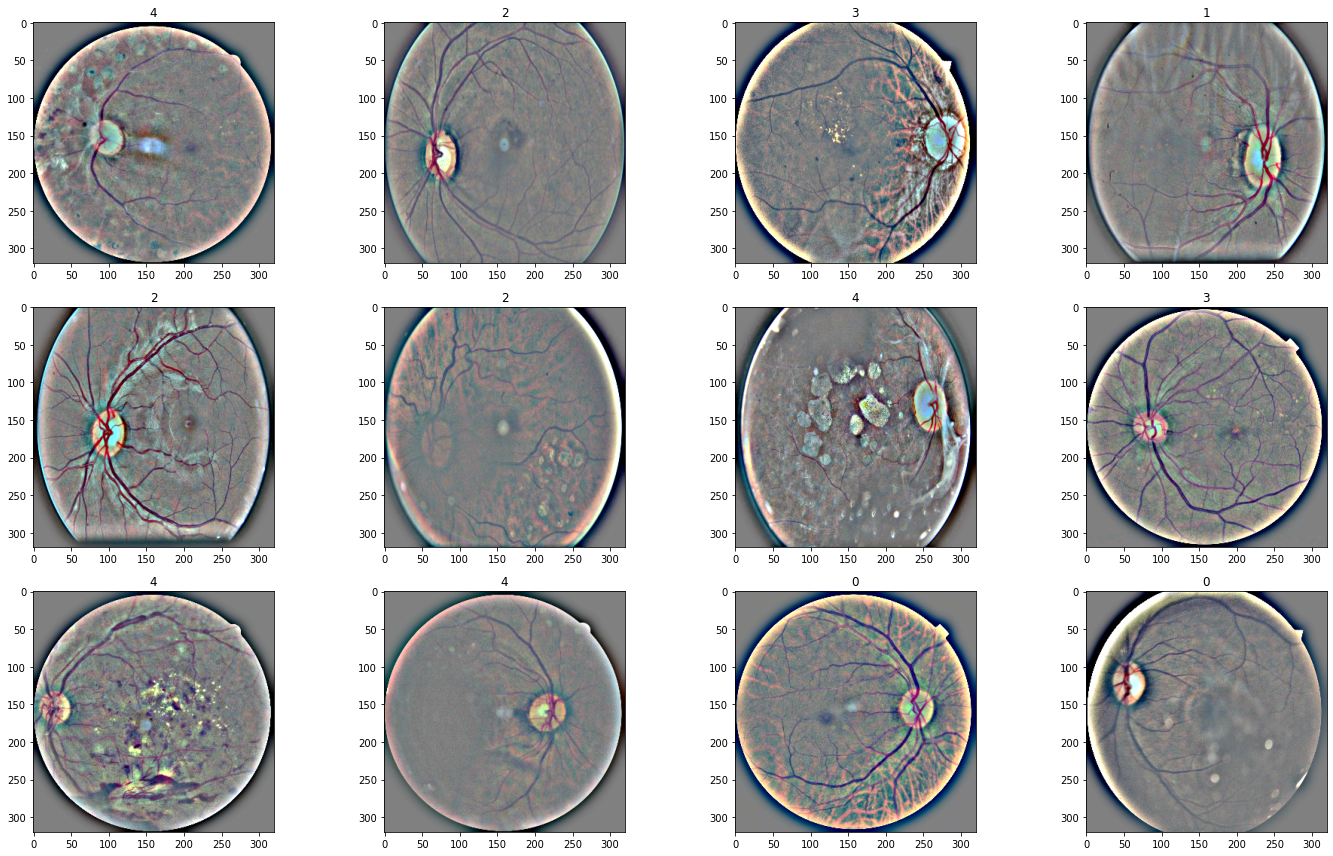

In [ ]:
%cd /gdrive/My Drive/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'image']
        image_id = df.loc[i,'level']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Processing Images

__UPDATE:__ Here we are reading just the validation set. In order to use 320x320 images, we are going to load one bucket at a time only when needed. This will let our code run without memory-related errors.

In [ ]:
# validation set
N = val_df.shape[0]
x_val = np.empty((N, im_size, im_size, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm_notebook(val_df['image'])):
    x_val[i, :, :, :] = preprocess_image(
        f'{image_id}',
        desired_size = im_size
    )

In [ ]:
y_train = pd.get_dummies(train_df['level']).values
y_val = pd.get_dummies(val_df['level']).values

print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(2597, 5)
(1113, 320, 320, 3)
(1113, 5)


# Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [ ]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
y_val_multi[:, 4] = y_val[:, 4]

for i in range(3, -1, -1):
    y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

print("Y_train multi: {}".format(y_train_multi.shape))
print("Y_val multi: {}".format(y_val_multi.shape))

Y_train multi: (2597, 5)
Y_val multi: (1113, 5)


In [ ]:
y_train = y_train_multi
y_val = y_val_multi

# Creating keras callback for QWK

---

I had to change this function, in order to consider the best kappa score among all the buckets.

In [ ]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('denseNet(5).h5')

        return

# Data Generator

In [ ]:
def create_datagen():
    return ImageDataGenerator(
        featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 360
    )

# Model: DenseNet-121

In [ ]:
densenet = DenseNet121(
    weights='/gdrive/My Drive/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(im_size,im_size,3)
)

In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0001,decay=1e-6),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# Training & Evaluation

In [ ]:
#train_df = train_df.reset_index(drop=True)
bucket_num = 8
# bucket_num = 3
div = round(train_df.shape[0]/bucket_num)

In [ ]:
df_init = {
    'val_loss': [0.0],
    'val_accuracy': [0.0],
    'loss': [0.0], 
    'accuracy': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

In [ ]:
# I found that changing the nr. of epochs for each bucket helped in terms of performances
epochs = [5,5,10,15,15,20,20,30]
# epochs = [5,5,10]
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []

In [ ]:
for i in range(0,bucket_num):
    if i != (bucket_num-1):
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:(1+i)*div].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:(1+i)*div,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', desired_size = im_size)

        data_generator = create_datagen().flow(x_train, y_train[i*div:(1+i)*div,:], batch_size=BATCH_SIZE)
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i
    else:
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', desired_size = im_size)
        data_generator = create_datagen().flow(x_train, y_train[i*div:,:], batch_size=BATCH_SIZE)
        
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i

    results = results.append(df_model)
    
    del data_generator
    del x_train
    gc.collect()
    
    print('-'*40)

Bucket Nr: 0




Epoch 1/5
17/16 [===============================] - 81s 5s/step - loss: 0.7030 - accuracy: 0.6314 - val_loss: 0.7375 - val_accuracy: 0.6800
val_kappa: 0.1545
Validation Kappa has improved. Saving model.
Epoch 2/5
17/16 [===============================] - 35s 2s/step - loss: 0.5166 - accuracy: 0.7649 - val_loss: 0.7857 - val_accuracy: 0.6518
val_kappa: 0.1124
Epoch 3/5
17/16 [===============================] - 42s 2s/step - loss: 0.4158 - accuracy: 0.8191 - val_loss: 0.9764 - val_accuracy: 0.6410
val_kappa: 0.0848
Epoch 4/5
17/16 [===============================] - 35s 2s/step - loss: 0.3589 - accuracy: 0.8345 - val_loss: 0.9940 - val_accuracy: 0.6548
val_kappa: 0.1255
Epoch 5/5
17/16 [===============================] - 35s 2s/step - loss: 0.3361 - accuracy: 0.8462 - val_loss: 0.7484 - val_accuracy: 0.7035
val_kappa: 0.2763
Validation Kappa has improved. Saving model.
----------------------------------------
Bucket Nr: 1



Epoch 1/5
17/16 [===============================] - 35s 2s/step - loss: 0.3455 - accuracy: 0.8572 - val_loss: 0.4604 - val_accuracy: 0.7892
val_kappa: 0.5079
Validation Kappa has improved. Saving model.
Epoch 2/5
17/16 [===============================] - 35s 2s/step - loss: 0.3395 - accuracy: 0.8615 - val_loss: 0.4793 - val_accuracy: 0.7919
val_kappa: 0.5197
Validation Kappa has improved. Saving model.
Epoch 3/5
17/16 [===============================] - 40s 2s/step - loss: 0.2900 - accuracy: 0.8732 - val_loss: 0.4091 - val_accuracy: 0.8257
val_kappa: 0.6354
Validation Kappa has improved. Saving model.
Epoch 4/5
17/16 [===============================] - 35s 2s/step - loss: 0.2856 - accuracy: 0.8769 - val_loss: 0.3792 - val_accuracy: 0.8410
val_kappa: 0.6612
Validation Kappa has improved. Saving model.
Epoch 5/5
17/16 [===============================] - 35s 2s/step - loss: 0.2815 - accuracy: 0.8782 - val_loss: 0.3788 - val_accuracy: 0.8397
val_kappa: 0.6441
-----------------------------


Epoch 1/10
17/16 [===============================] - 36s 2s/step - loss: 0.3211 - accuracy: 0.8560 - val_loss: 0.3465 - val_accuracy: 0.8507
val_kappa: 0.6869
Validation Kappa has improved. Saving model.
Epoch 2/10
17/16 [===============================] - 35s 2s/step - loss: 0.3129 - accuracy: 0.8665 - val_loss: 0.3314 - val_accuracy: 0.8570
val_kappa: 0.6970
Validation Kappa has improved. Saving model.
Epoch 3/10
17/16 [===============================] - 35s 2s/step - loss: 0.3157 - accuracy: 0.8720 - val_loss: 0.3515 - val_accuracy: 0.8537
val_kappa: 0.7118
Validation Kappa has improved. Saving model.
Epoch 4/10
17/16 [===============================] - 35s 2s/step - loss: 0.2682 - accuracy: 0.8862 - val_loss: 0.3164 - val_accuracy: 0.8642
val_kappa: 0.7215
Validation Kappa has improved. Saving model.
Epoch 5/10
17/16 [===============================] - 35s 2s/step - loss: 0.2247 - accuracy: 0.9040 - val_loss: 0.3461 - val_accuracy: 0.8503
val_kappa: 0.7126
Epoch 6/10
17/16 [======


Epoch 1/15
17/16 [===============================] - 35s 2s/step - loss: 0.3445 - accuracy: 0.8609 - val_loss: 0.3310 - val_accuracy: 0.8586
val_kappa: 0.6683
Epoch 2/15
17/16 [===============================] - 35s 2s/step - loss: 0.2928 - accuracy: 0.8714 - val_loss: 0.5074 - val_accuracy: 0.8189
val_kappa: 0.5334
Epoch 3/15
17/16 [===============================] - 35s 2s/step - loss: 0.2675 - accuracy: 0.8874 - val_loss: 0.4415 - val_accuracy: 0.8386
val_kappa: 0.5917
Epoch 4/15
17/16 [===============================] - 35s 2s/step - loss: 0.2261 - accuracy: 0.9071 - val_loss: 0.4494 - val_accuracy: 0.8358
val_kappa: 0.5984
Epoch 5/15
17/16 [===============================] - 35s 2s/step - loss: 0.2520 - accuracy: 0.8880 - val_loss: 0.3684 - val_accuracy: 0.8586
val_kappa: 0.6777
Epoch 6/15
17/16 [===============================] - 35s 2s/step - loss: 0.2027 - accuracy: 0.9089 - val_loss: 0.4198 - val_accuracy: 0.8492
val_kappa: 0.6328
Epoch 7/15
17/16 [===========================


Epoch 1/15
17/16 [===============================] - 35s 2s/step - loss: 0.3721 - accuracy: 0.8566 - val_loss: 0.4418 - val_accuracy: 0.8681
val_kappa: 0.7201
Epoch 2/15
17/16 [===============================] - 35s 2s/step - loss: 0.3061 - accuracy: 0.8775 - val_loss: 0.3605 - val_accuracy: 0.8620
val_kappa: 0.6870
Epoch 3/15
17/16 [===============================] - 35s 2s/step - loss: 0.2746 - accuracy: 0.8849 - val_loss: 0.3624 - val_accuracy: 0.8625
val_kappa: 0.6852
Epoch 4/15
17/16 [===============================] - 35s 2s/step - loss: 0.2356 - accuracy: 0.8985 - val_loss: 0.4101 - val_accuracy: 0.8634
val_kappa: 0.7102
Epoch 5/15
17/16 [===============================] - 35s 2s/step - loss: 0.2435 - accuracy: 0.8929 - val_loss: 0.4901 - val_accuracy: 0.8406
val_kappa: 0.6572
Epoch 6/15
17/16 [===============================] - 35s 2s/step - loss: 0.2108 - accuracy: 0.9145 - val_loss: 0.4777 - val_accuracy: 0.8395
val_kappa: 0.6406
Epoch 7/15
17/16 [===========================


Epoch 1/20
17/16 [===============================] - 36s 2s/step - loss: 0.3865 - accuracy: 0.8542 - val_loss: 0.4713 - val_accuracy: 0.8304
val_kappa: 0.6574
Epoch 2/20
17/16 [===============================] - 35s 2s/step - loss: 0.3550 - accuracy: 0.8800 - val_loss: 0.4392 - val_accuracy: 0.8228
val_kappa: 0.5673
Epoch 3/20
17/16 [===============================] - 35s 2s/step - loss: 0.2537 - accuracy: 0.8905 - val_loss: 0.3958 - val_accuracy: 0.8438
val_kappa: 0.6484
Epoch 4/20
17/16 [===============================] - 35s 2s/step - loss: 0.1967 - accuracy: 0.9102 - val_loss: 0.4768 - val_accuracy: 0.8169
val_kappa: 0.5696
Epoch 5/20
17/16 [===============================] - 35s 2s/step - loss: 0.1922 - accuracy: 0.9157 - val_loss: 0.5434 - val_accuracy: 0.7962
val_kappa: 0.5210
Epoch 6/20
17/16 [===============================] - 35s 2s/step - loss: 0.2103 - accuracy: 0.9058 - val_loss: 0.8247 - val_accuracy: 0.7628
val_kappa: 0.4647
Epoch 7/20
17/16 [===========================


Epoch 1/20
17/16 [===============================] - 36s 2s/step - loss: 0.3963 - accuracy: 0.8554 - val_loss: 0.3866 - val_accuracy: 0.8627
val_kappa: 0.7290
Epoch 2/20
17/16 [===============================] - 35s 2s/step - loss: 0.3480 - accuracy: 0.8732 - val_loss: 0.6059 - val_accuracy: 0.8122
val_kappa: 0.5253
Epoch 3/20
17/16 [===============================] - 35s 2s/step - loss: 0.2510 - accuracy: 0.8917 - val_loss: 0.9270 - val_accuracy: 0.7562
val_kappa: 0.3641
Epoch 4/20
17/16 [===============================] - 35s 2s/step - loss: 0.2191 - accuracy: 0.9138 - val_loss: 0.5298 - val_accuracy: 0.8219
val_kappa: 0.5569
Epoch 5/20
17/16 [===============================] - 35s 2s/step - loss: 0.2154 - accuracy: 0.9102 - val_loss: 0.5053 - val_accuracy: 0.8219
val_kappa: 0.5650
Epoch 6/20
17/16 [===============================] - 35s 2s/step - loss: 0.2012 - accuracy: 0.9169 - val_loss: 0.3727 - val_accuracy: 0.8624
val_kappa: 0.7029
Epoch 7/20
17/16 [===========================


Epoch 1/30
17/16 [===============================] - 39s 2s/step - loss: 0.3742 - accuracy: 0.8714 - val_loss: 0.5945 - val_accuracy: 0.8449
val_kappa: 0.6403
Epoch 2/30
17/16 [===============================] - 35s 2s/step - loss: 0.3435 - accuracy: 0.8733 - val_loss: 0.8806 - val_accuracy: 0.8059
val_kappa: 0.5287
Epoch 3/30
17/16 [===============================] - 35s 2s/step - loss: 0.2410 - accuracy: 0.9050 - val_loss: 0.5915 - val_accuracy: 0.8528
val_kappa: 0.6479
Epoch 4/30
17/16 [===============================] - 35s 2s/step - loss: 0.1906 - accuracy: 0.9168 - val_loss: 0.4496 - val_accuracy: 0.8692
val_kappa: 0.7136
Epoch 5/30
17/16 [===============================] - 35s 2s/step - loss: 0.1890 - accuracy: 0.9174 - val_loss: 0.3980 - val_accuracy: 0.8618
val_kappa: 0.7204
Epoch 6/30
17/16 [===============================] - 35s 2s/step - loss: 0.2086 - accuracy: 0.9304 - val_loss: 0.4443 - val_accuracy: 0.8584
val_kappa: 0.7122
Epoch 7/30
17/16 [===========================

In [ ]:
results = results.iloc[1:]
results['kappa'] = kappa_metrics.val_kappas
results = results.reset_index()
results = results.rename(index=str, columns={"index": "epoch"})
results

,epoch,val_loss,val_accuracy,loss,accuracy,bucket,kappa
0,0,0.737511,0.679964,0.700783,0.631385,0.0,0.154463
1,1,0.785749,0.651752,0.512658,0.764923,0.0,0.112413
2,2,0.976449,0.640970,0.411665,0.819077,0.0,0.084775
3,3,0.993986,0.654807,0.358138,0.834462,0.0,0.125526
4,4,0.748379,0.703504,0.338262,0.846154,0.0,0.276269
...,...,...,...,...,...,...,...
115,25,0.497356,0.854807,0.093464,0.967702,7.0,0.718723
116,26,0.577456,0.843486,0.064203,0.979503,7.0,0.710106
117,27,0.568988,0.840431,0.050303,0.985093,7.0,0.724479
118,28,0.531917,0.844385,0.057429,0.981988,7.0,0.714021


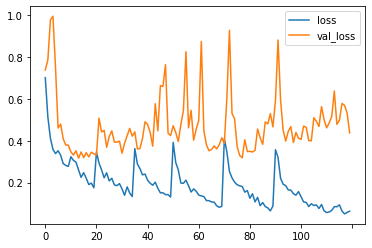

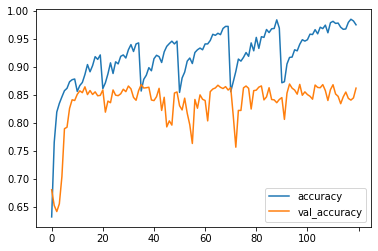

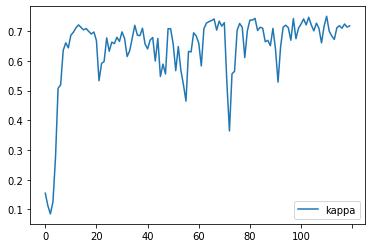

In [ ]:
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()
results[['kappa']].plot()
results.to_csv('results(5).csv',index=False)

# Find best threshold

In [ ]:
model.load_weights('denseNet(5).h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

y1 = y_val_pred > best_threshold
y1 = y1.astype(int).sum(axis=1) - 1
y2 = y_val.sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Threshold: {}'.format(best_threshold))
print('Validation QWK score with best_threshold: {}'.format(score))

y1 = y_val_pred > .5
y1 = y1.astype(int).sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Validation QWK score with .5 threshold: {}'.format(score))

Threshold: 0.5125
Validation QWK score with best_threshold: 0.7522981981597588
Validation QWK score with .5 threshold: 0.7506235809584101


In [ ]:
%mv denseNet\(5\).h5 results\(5\).csv ../

In [ ]:
y_best = y_val_pred > best_threshold
y_best  = y_best .astype(int).sum(axis=1) - 1
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_best, y2))
print('Classification Report')
target_names = ['No DR', 'Mild', 'Moderate','Severe','Poliferative']
print(classification_report(y_best, y2, target_names=target_names))

Confusion Matrix
[[123 114  32   6   1]
 [ 95 111  73  20   8]
 [  9  11  47  14  15]
 [  6   5  60 142  79]
 [  5   2   9  11 115]]
Classification Report
              precision    recall  f1-score   support

       No DR       0.52      0.45      0.48       276
        Mild       0.46      0.36      0.40       307
    Moderate       0.21      0.49      0.30        96
      Severe       0.74      0.49      0.59       292
Poliferative       0.53      0.81      0.64       142

    accuracy                           0.48      1113
   macro avg       0.49      0.52      0.48      1113
weighted avg       0.53      0.48      0.49      1113



In [ ]:
# score = model.evaluate(x_val, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Inference Kernel

https://www.kaggle.com/raimonds1993/aptos19-densenet-trained-with-old-and-new-data
